<a href="https://colab.research.google.com/github/krystaldowling/MAST30034_Final_Project-/blob/CNN_Model/3Channel_GloVe_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This document contains modified code from https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/. 

In [1]:
# Import statements
import pandas as pd
from nltk import word_tokenize
from numpy import array
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [4]:
# Loading in preproccessed data
PATH = "/content/drive/My Drive/Data/"
data = pd.read_csv(PATH + "preproccessed_data.csv", lineterminator='\n')

data

,title,text,label
0,muslims busted stole millions gov ’ benefits,print pay back money plus interest entire fami...,1
1,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1
2,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1
3,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1
4,fantastic trumps 7 point plan reform healthcar...,email healthcare reform make america great sin...,1
...,...,...,...
29449,process analytical instruments market – techna...,technavio published new report global process ...,0
29450,travel deals get 1200 air credit two apt cookt...,apt offering savings new cape york outback wil...,0
29451,taiwanese recyclers belief waste simply mispla...,taipei taiwan sept 8 2015 prnewswire recent ye...,0
29452,season curtain raiser ideal way honour john,blackburn sunday league john haydock memorial ...,0


In [ ]:
# Performing test-train split
data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

In [ ]:
# Tokenizing data
def tokenize_text(text):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(text)
	return tokenizer

tokenizer = tokenize_text(data_train['text'])

In [ ]:
# Find vocabulary size
vocab_size = len(tokenizer.word_index) + 1

print('Vocabulary size: %d' % vocab_size)

Vocabulary size: 221431


In [ ]:
# Encode lines
def encode_text(tokenizer, lines, length):
  encoded = tokenizer.texts_to_sequences(lines)
  # Pad the encoded sequences
  padded = pad_sequences(encoded, maxlen=length, padding='post')
  return padded

# Set maxlen to 500
maxlen = 500

encoded_data = encode_text(tokenizer, data_train['text'], maxlen)
encoded_data_testing = encode_text(tokenizer, data_test['text'], maxlen)

(26540, 500)


In [ ]:
# Fitting GloVe embeddings
EMBEDDING_FILE = '/content/drive/My Drive/Data/glove.6B.100d.txt'

def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (vocab_size, embed_size))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector;

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
def define_model(length, vocab_size):
	# Channel 1
	inputs1 = Input(shape=(length,))
	embedding1 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(inputs1)
	conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
	drop1 = Dropout(0.5)(conv1)
	pool1 = MaxPooling1D(pool_size=2)(drop1)
	flat1 = Flatten()(pool1)
	# Channel 2
	inputs2 = Input(shape=(length,))
	embedding2 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(inputs2)
	conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
	drop2 = Dropout(0.5)(conv2)
	pool2 = MaxPooling1D(pool_size=2)(drop2)
	flat2 = Flatten()(pool2)
	# Channel 3
	inputs3 = Input(shape=(length,))
	embedding3 = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(inputs3)
	conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
	drop3 = Dropout(0.5)(conv3)
	pool3 = MaxPooling1D(pool_size=2)(drop3)
	flat3 = Flatten()(pool3)
	# Merge Channels
	merged = concatenate([flat1, flat2, flat3])
	dense1 = Dense(10, activation='relu')(merged)
	outputs = Dense(1, activation='sigmoid')(dense1)
	model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
	# Print model summary
	print(model.summary())
  # Save model plot
	plot_model(model, show_shapes=True, to_file='multichannel.png')
	return model


In [ ]:
# define model
model = define_model(maxlen, vocab_size)
# fit model
history = model.fit([encoded_data, encoded_data, encoded_data], array(data_train['label']), epochs=50, batch_size=16, validation_data=([encoded_data_testing, encoded_data_testing, encoded_data_testing], array(data_test['label'])))
# save the model
model.save('model.h5')


Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 500, 100)     22143100    input_19[0][0]                   
______________________________________________________________________________________

In [ ]:
# Evaluate model accuracy on training dataset
loss_train, acc_train = model.evaluate([encoded_data, encoded_data, encoded_data], array(data_train['label']), verbose=0)
print('Train Accuracy: %f' % (acc_train*100))
 
# Evaluate model accuracy on test dataset
loss_test, acc_test = model.evaluate([encoded_data_testing, encoded_data_testing, encoded_data_testing],array(data_test['label']), verbose=0)
print('Test Accuracy: %f' % (acc_test*100))

Train Accuracy: 99.913341
Test Accuracy: 82.977283


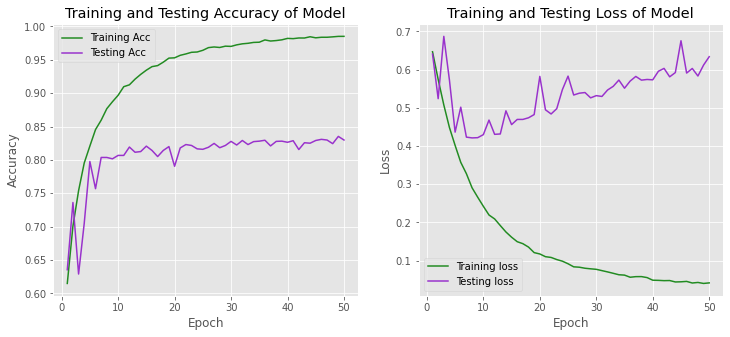

In [ ]:
# Code modified from https://realpython.com/python-keras-text-classification/

plt.style.use('ggplot')

# Function to print plot of accuracy and loss of training and test data
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'forestgreen', label='Training Acc')
    plt.plot(x, val_acc, 'darkorchid', label='Testing Acc')
    plt.title('Training and Testing Accuracy of Model')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch') 
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'forestgreen', label='Training loss')
    plt.plot(x, val_loss, 'darkorchid', label='Testing loss')
    plt.title('Training and Testing Loss of Model')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

# Plot model data
plot_history(history)